In [42]:
import pickle
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import validation_curve

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score


import matplotlib.pyplot as plt
import seaborn as sns


In [43]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## SPLIT

In [44]:
df = pd.read_feather("../data_model/houses.feather")
df.head(1)

,log_buy_price,sq_mt_built,n_rooms,n_bathrooms,neighborhood,has_lift,has_parking,has_pool,has_garden,has_storage_room,is_floor_under
0,11.350418,64.0,2,1.0,135,0.0,0,0,0,0,0.0


In [45]:
X = df.drop(columns=['log_buy_price'])
y = df['log_buy_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape) 

(17163, 10)
(17163,)
(4291, 10)
(4291,)


In [47]:
# Train
X_train.reset_index(drop=True).to_feather("../data_model/X_train.feather")
y_train.reset_index(drop=True).to_frame("log_buy_price").to_feather("../data_model/y_train.feather")

# Test
X_test.reset_index(drop=True).to_feather("../data_model/X_test.feather")
y_test.reset_index(drop=True).to_frame("log_buy_price").to_feather("../data_model/y_test.feather")

In [48]:
# df.to_feather(r'data/houses.feather')
X_train = pd.read_feather("../data_model/X_train.feather")
y_train = pd.read_feather("../data_model/y_train.feather")
X_test = pd.read_feather("../data_model/X_test.feather")
y_test = pd.read_feather("../data_model/y_test.feather")

# Convertit y en Series 1d
y_train = y_train.iloc[:,0]
y_test  = y_test.iloc[:,0]

## PREPROCESSING - StandardScaler + Variables catégorielles

Le StandardScaler est **crucial** pour la régression linéaire car :
- Les variables ont des échelles très différentes (surface vs nombre de pièces)
- Sans normalisation, les coefficients sont biaisés vers les variables à grande échelle
- Les algorithmes convergent plus rapidement avec des données normalisées

In [49]:
# ✅ 1) Forcer neighborhood en catégoriel (car il est en int64 mais c'est une catégorie)
X_train["neighborhood"] = X_train["neighborhood"].astype("category")
X_test["neighborhood"]  = X_test["neighborhood"].astype("category")

# ✅ 2) Définir explicitement les colonnes
categorical_features = ["neighborhood"]

# Toutes les autres colonnes = numériques (dans ton dataset)
numeric_features = [c for c in X_train.columns if c not in categorical_features]

print(f"Features numériques ({len(numeric_features)}): {numeric_features}")
print(f"Features catégorielles ({len(categorical_features)}): {categorical_features}")

# ✅ 3) Préprocesseur :
# - StandardScaler pour les numériques (utile pour LR/Ridge/Lasso)
# - OneHotEncoder pour neighborhood (pas d'ordre artificiel)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=False), categorical_features),
    ]
)

# ✅ 4) Fit/transform - GARDER les noms originaux ET créer les versions scalées
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled  = preprocessor.transform(X_test)

print("\nDonnées transformées:")
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"X_test_scaled shape : {X_test_scaled.shape}")
print(f"Type: {type(X_train_scaled)}")

print(f"\nDonnées originales conservées:")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape : {X_test.shape}")

Features numériques (9): ['sq_mt_built', 'n_rooms', 'n_bathrooms', 'has_lift', 'has_parking', 'has_pool', 'has_garden', 'has_storage_room', 'is_floor_under']
Features catégorielles (1): ['neighborhood']

Données transformées:
X_train_scaled shape: (17163, 134)
X_test_scaled shape : (4291, 134)
Type: <class 'numpy.ndarray'>

Données originales conservées:
X_train shape: (17163, 10)
X_test shape : (4291, 10)


In [50]:
X_train.head()

,sq_mt_built,n_rooms,n_bathrooms,neighborhood,has_lift,has_parking,has_pool,has_garden,has_storage_room,is_floor_under
0,95.0,2,2.0,129,1.0,1,1,0,1,0.0
1,360.0,5,4.0,63,1.0,1,0,0,1,0.0
2,50.0,1,1.0,91,1.0,0,0,0,0,1.0
3,40.0,2,1.0,89,1.0,0,0,0,1,1.0
4,108.0,3,1.0,134,1.0,0,0,0,0,0.0


In [51]:
print(f"X_train : {X_train.shape}\ny_train : {y_train.shape}")

X_train : (17163, 10)
y_train : (17163,)


### Modele de base - Dummy Regressor

In [52]:
dummy = DummyRegressor(strategy="median")
dummy.fit(X_train_scaled, y_train)  # Dummy peut utiliser les données brutes

y_pred = dummy.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Dummy Regressor Performance:\nR²: {r2:.4f}\nRMSE: {rmse:.2f}\nMAE: {mae:.2f}")

Dummy Regressor Performance:
R²: -0.0121
RMSE: 0.92
MAE: 0.75


In [53]:
import numpy as np

print("y_train")
print(f"  mean   : {np.mean(y_train):.4f}")
print(f"  median : {np.median(y_train):.4f}")
print(f"  std    : {np.std(y_train):.4f}")
print(f"  min/max: {np.min(y_train):.4f} / {np.max(y_train):.4f}")

print("\ny_test")
print(f"  mean   : {np.mean(y_test):.4f}")
print(f"  median : {np.median(y_test):.4f}")
print(f"  std    : {np.std(y_test):.4f}")
print(f"  min/max: {np.min(y_test):.4f} / {np.max(y_test):.4f}")


y_train
  mean   : 12.9352
  median : 12.8347
  std    : 0.9161
  min/max: 10.5713 / 15.9788

y_test
  mean   : 12.9349
  median : 12.8347
  std    : 0.9122
  min/max: 10.4913 / 15.9903


### Regression Linéaire

In [54]:
# Régression Linéaire avec données scalées
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

print(f"R² train: {lr.score(X_train_scaled, y_train):.4f}")
print(f"R² test:  {lr.score(X_test_scaled, y_test):.4f}")

# Validation croisée avec données scalées
scores_lr = cross_val_score(lr, X_train_scaled, y_train, cv=5, scoring='r2')
print(f"R² CV moyenne: {scores_lr.mean():.4f} (+/- {scores_lr.std() * 2:.4f})")

R² train: 0.9058
R² test:  0.9010
R² CV moyenne: 0.9041 (+/- 0.0041)
R² CV moyenne: 0.9041 (+/- 0.0041)


In [55]:
lr.score(X_train_scaled, y_train)

0.9057582636791519

In [56]:
lr.score(X_test_scaled, y_test)

0.900990746215857

In [57]:
# scores = cross_val_score(lr, X_train, y_train, cv=5, scoring='r2')
# print("R² CV moyenne :", scores.mean())


In [58]:
# Génère des prédictions par validation croisée (avec X_train_scaled pour LR)
y_train_pred = cross_val_predict(lr, X_train_scaled, y_train, cv=5)

# Calcul les résidus
y_train_flat = y_train.values.flatten()
residuals = y_train_flat - y_train_pred.flatten()

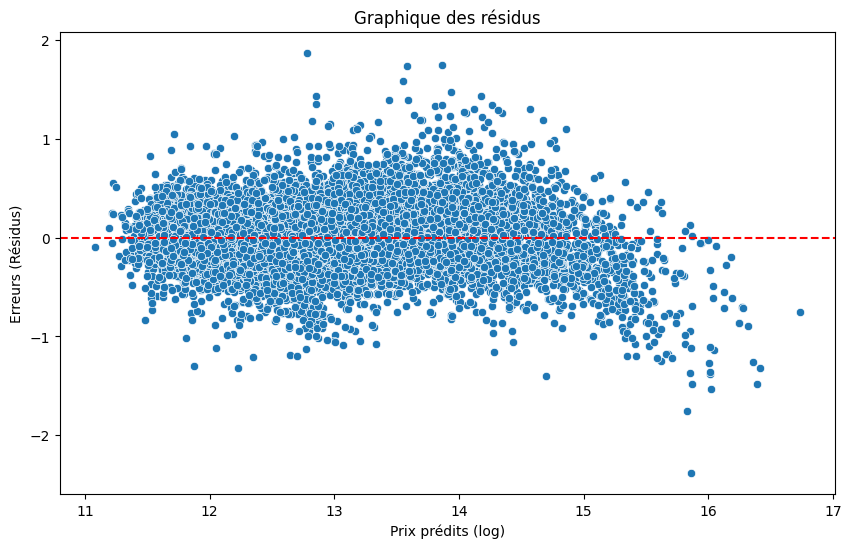

In [59]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_train_pred.ravel(), y=residuals)
plt.axhline(y=0, color='r', linestyle='--')  # Ligne horizontale à 0
plt.title('Graphique des résidus')
plt.xlabel('Prix prédits (log)')
plt.ylabel('Erreurs (Résidus)')
plt.show()

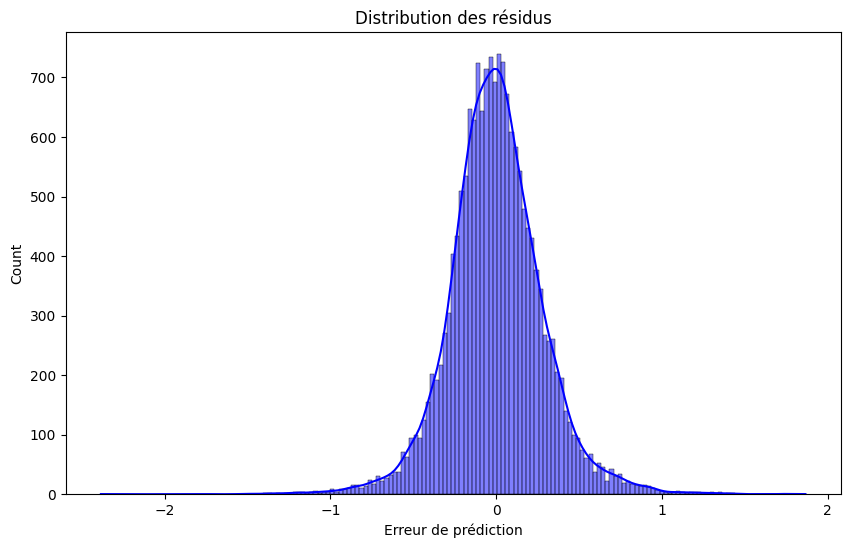

In [60]:
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color='blue')
plt.title('Distribution des résidus')
plt.xlabel('Erreur de prédiction')
plt.show()

In [ ]:
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
rf.score(X_train, y_train)

In [ ]:
rf_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='r2')
print("R² CV moyenne :", rf_scores.mean())

R² CV moyenne : 0.9433671633160783


Détection d'over fitting avec validation_curve

In [ ]:
# De 10 à 200 arbres, par pas de 10
#param_range = np.arange(10, 200, 10)

# détection d'overfitting avec validation_curve
#train_score, val_score = validation_curve(
    #rf, X_train, y_train, "n_estimators", param_range, cv=5)

# Autres paramètres possibles :
# max_depth : profondeur max des arbres (limite l'overfitting)
# min_samples_split : nombre min d'échantillons pour créer une split

#plt.plot(param_range, val_score.mean(axis=1), label="Validation Score")
#plt.plot(param_range, train_score.mean(axis=1), label="Training Score")
#plt.ylabel("Score R²")
#plt.xlabel("Number of Trees (N_estimators)")
#plt.legend()
#plt.grid(True, alpha=0.3)

In [ ]:
# # 49 valeurs
# k = np.arrange(1,50)
# # 49 valeurs sont testées avec cv=5
# train_score, val_score = validation_curve(model, X_train, y_train, 'n_neighbors', k, cv=5)

## 🏆 COMPARATIF FINAL DES MODÈLES

In [ ]:
# Comparatif final des modèles
models = {
    'Baseline (Dummy)': dummy,
    'Linear Regression': lr,
    'Random Forest': rf
}

results = []

for name, model in models.items():
    if name == 'Baseline (Dummy)':
        # Dummy utilise les données brutes
        train_score = model.score(X_train, y_train)
        test_score = model.score(X_test, y_test)
    elif name == 'Linear Regression':
        # LR utilise les données scalées
        train_score = model.score(X_train_scaled, y_train)
        test_score = model.score(X_test_scaled, y_test)
    else:
        # RF peut utiliser les données brutes (pas sensible à l'échelle)
        train_score = model.score(X_train, y_train)
        test_score = model.score(X_test, y_test)
    
    results.append({
        'Modèle': name,
        'R² Train': f"{train_score:.4f}",
        'R² Test': f"{test_score:.4f}",
        'Overfitting': f"{train_score - test_score:.4f}"
    })

# Affichage du tableau
results_df = pd.DataFrame(results)
print("📊 PERFORMANCE DES MODÈLES:")
print(results_df.to_string(index=False))

# Sélection du meilleur modèle
best_model = max(models.items(), key=lambda x: x[1].score(
    X_test_scaled if x[0] == 'Linear Regression' else X_test, y_test
))

print(f"\n🏆 MEILLEUR MODÈLE: {best_model[0]}")
print(f"Score R² test: {best_model[1].score(X_test_scaled if best_model[0] == 'Linear Regression' else X_test, y_test):.4f}")

📊 PERFORMANCE DES MODÈLES:
           Modèle R² Train R² Test Overfitting
 Baseline (Dummy)  -0.0120 -0.0121      0.0000
Linear Regression   0.9058  0.9010      0.0048
    Random Forest   0.9907  0.9474      0.0433

🏆 MEILLEUR MODÈLE: Random Forest
Score R² test: 0.9474


In [ ]:
# Sauvegarde du modèle et des transformateurs
import pickle
import os

os.makedirs("../models", exist_ok=True)

# Sauvegarder le meilleur modèle
with open("../models/best_model.pkl", "wb") as f:
    pickle.dump(best_model[1], f)

# Sauvegarder le preprocesseur (important pour l'API !)
with open("../models/preprocessor.pkl", "wb") as f:
    pickle.dump(preprocessor, f)

# Sauvegarder les métadonnées
metadata = {
    'model_name': best_model[0],
    'features': numeric_features + categorical_features,
    'numeric_features': numeric_features,
    'categorical_features': categorical_features,
    'test_score': best_model[1].score(
        X_test_scaled if best_model[0] == 'Linear Regression' else X_test, y_test
    )
}

with open("../models/model_metadata.pkl", "wb") as f:
    pickle.dump(metadata, f)

print("✅ Modèle et preprocessing sauvegardés dans models/")
print(f"✅ Modèle: {best_model[0]}")
print(f"✅ Performance: {metadata['test_score']:.4f} R²")
print(f"✅ Features: {len(metadata['features'])} variables")

✅ Modèle et preprocessing sauvegardés dans models/
✅ Modèle: Random Forest
✅ Performance: 0.9474 R²
✅ Features: 10 variables


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# --- Dummy
y_pred_dummy_log = dummy.predict(X_test_scaled)

# --- RF (exemple : rf_pipeline est ton pipeline entraîné)
y_pred_rf_log = rf_pipeline.predict(X_test)  # ou X_test_scaled selon ton code

def euro_metrics(y_true_log, y_pred_log):
    y_true_eur = np.exp(y_true_log)
    y_pred_eur = np.exp(y_pred_log)
    mae = mean_absolute_error(y_true_eur, y_pred_eur)
    rmse = np.sqrt(mean_squared_error(y_true_eur, y_pred_eur))
    return mae, rmse

def pct_metrics(y_true_log, y_pred_log):
    ratio = np.exp(y_pred_log - y_true_log)
    abs_pct = np.abs(ratio - 1) * 100
    return abs_pct.mean(), np.median(abs_pct), np.percentile(abs_pct, 90)

mae_d, rmse_d = euro_metrics(y_test.values, y_pred_dummy_log)
mmean_d, mmed_d, p90_d = pct_metrics(y_test.values, y_pred_dummy_log)

mae_rf, rmse_rf = euro_metrics(y_test.values, y_pred_rf_log)
mmean_rf, mmed_rf, p90_rf = pct_metrics(y_test.values, y_pred_rf_log)

print("DUMMY  | MAE€:", round(mae_d), "RMSE€:", round(rmse_d),
      "| mean%:", round(mmean_d,1), "med%:", round(mmed_d,1), "p90%:", round(p90_d,1))

print("RF     | MAE€:", round(mae_rf), "RMSE€:", round(rmse_rf),
      "| mean%:", round(mmean_rf,1), "med%:", round(mmed_rf,1), "p90%:", round(p90_rf,1))


NameError: name 'rf_pipeline' is not defined